# Read in Data

In [74]:
# ================================================================================
# Splitting training and test sets
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('WAGE2_2025_abridged.csv')

state= (540491669 + 540712391 + 540575497 + 540750669 + 540744934)   # replace this number with the sum of the student IDs for the members of your group

train = data.sample(frac=0.8, random_state=state)
test = data[data.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [75]:
train.head()

,wage,hours,IQ,KWW,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc,lwage
0,1160,40,92,32,12,8,8,31,1,0,0,0,4,1.0,12.0,11.0,7.056175
1,722,55,113,36,16,8,1,38,0,0,1,1,1,2.0,8.0,NaN,6.582025
2,1160,40,84,35,12,17,2,38,1,0,0,0,4,2.0,16.0,12.0,7.056175
3,1000,50,104,36,16,11,8,30,1,0,0,1,1,1.0,12.0,11.0,6.907755
4,978,48,104,36,12,19,15,36,1,0,0,1,5,6.0,6.0,NaN,6.885510


# **Task 1**

# **Task 2**

### MLR of education and experience on wage

In [78]:
t2_model = smf.ols('wage ~ educ + exper', data=train)
t2_reg = t2_model.fit()
t2_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     55.84
Date:                Mon, 12 May 2025   Prob (F-statistic):           2.72e-23
Time:                        16:37:19   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    122.739     -2.353      0.019    -529.742     -47.814
educ          76.1294      7.216     10.550      0.000      61.963      90.296
exper         19.4915      3.534      5.516      0.000      12.554      26.429
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
#Extracting Fitted Values and Residuals from the Regression Model
t2_fit = t2_reg.fittedvalues
t2_resid = t2_reg.resid

In [80]:
t2_reg.mse_resid**0.5

375.5059302119657

In [81]:
t2_reg_rob = t2_model.fit(cov_type = 'HC0')
t2_reg_rob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     47.42
Date:                Mon, 12 May 2025   Prob (F-statistic):           4.36e-20
Time:                        16:37:19   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    128.375     -2.249      0.024    -540.388     -37.168
educ          76.1294      7.848      9.700      0.000      60.747      91.512
exper         19.4915      3.479      5.603      0.000      12.673      26.310
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

After correcting for potential heteroskedasticity using HC1 robust standard errors, the model’s coefficients remained statistically significant, suggesting that the key relationships are robust. However, the increase in standard errors and the lower F-statistic indicate that inference under standard OLS may have understated uncertainty.

In [122]:
t2_slr_educ_model = smf.ols('wage ~ educ', data=train).fit()
t2_slr_educ_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     78.11
Date:                Mon, 12 May 2025   Prob (F-statistic):           7.21e-18
Time:                        16:41:28   Log-Likelihood:                -5399.0
No. Observations:                 733   AIC:                         1.080e+04
Df Residuals:                     731   BIC:                         1.081e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    188.8699     88.719      2.129      0.034      14.695     363.045
educ          57.3342      6.487      8.838      0.000      44.598      70.070
==============================================================================
Omnibus:                      179.416   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              550.454
Skew:                           1.179   Prob(JB):                    2.95e-120
Kurtosis:                       6.531   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
t2_slr_exper_model = smf.ols('wage ~ exper', data=train).fit()
t2_slr_exper_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3188
Date:                Mon, 12 May 2025   Prob (F-statistic):              0.572
Time:                        16:42:04   Log-Likelihood:                -5436.0
No. Observations:                 733   AIC:                         1.088e+04
Df Residuals:                     731   BIC:                         1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    941.2470     41.168     22.863      0.000     860.425    1022.069
exper          1.8868      3.342      0.565      0.572      -4.673       8.447
==============================================================================
Omnibus:                      186.803   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.904
Skew:                           1.275   Prob(JB):                    1.89e-111
Kurtosis:                       6.193   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LSA 1: Linearity

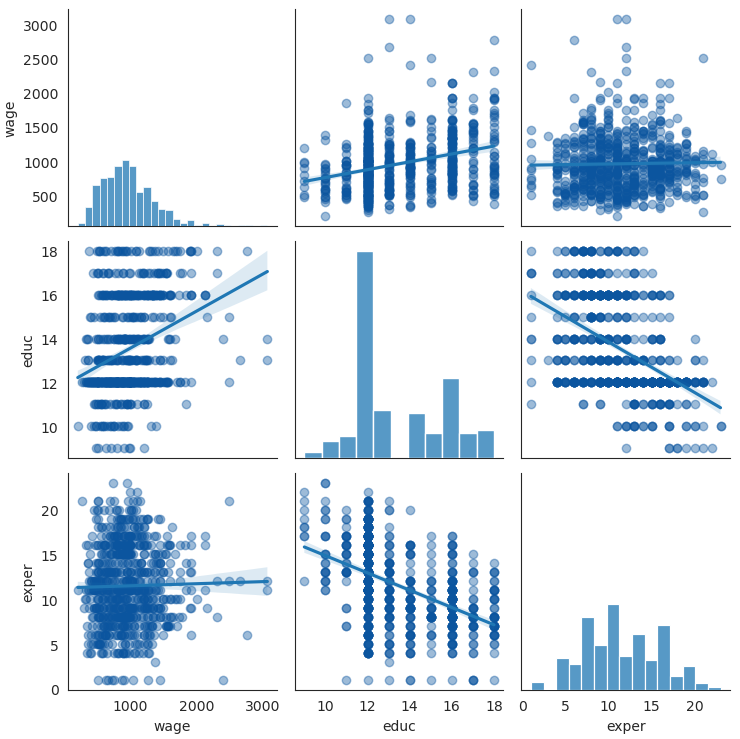

In [84]:

variables=['wage', 'educ', 'exper']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg',
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})
plt.tight_layout()

### LSA 2: Exogeneity

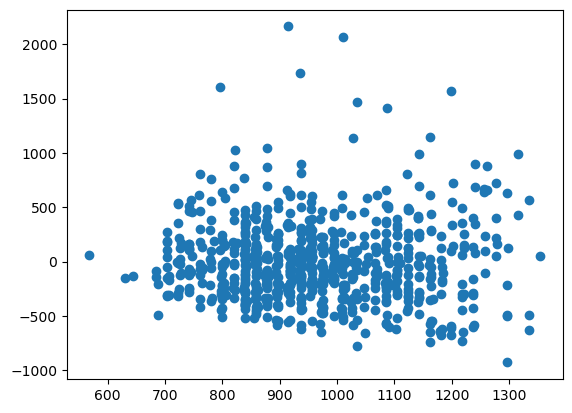

In [86]:
plt.scatter(t2_fit, t2_resid)
plt.show()

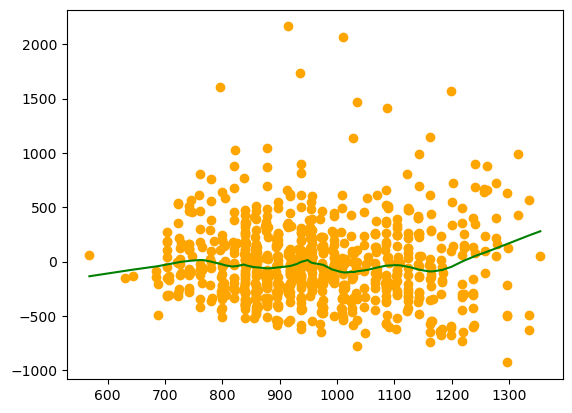

In [87]:
lowess = sm.nonparametric.lowess
plt.scatter(t2_fit, t2_resid, color='orange')
t2_z = lowess(t2_resid, t2_fit, frac=1./5)
plt.plot(t2_z[:,0],t2_z[:,1],'green')
plt.show()

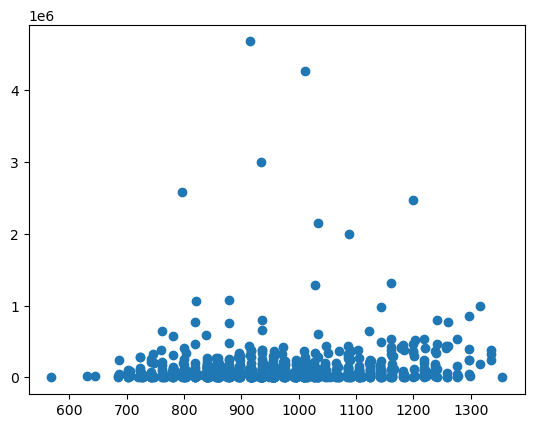

In [88]:
#Squared Residuals for MLR
t2_resid2=t2_reg.resid**2
plt.scatter(t2_fit, t2_resid2)
plt.show()

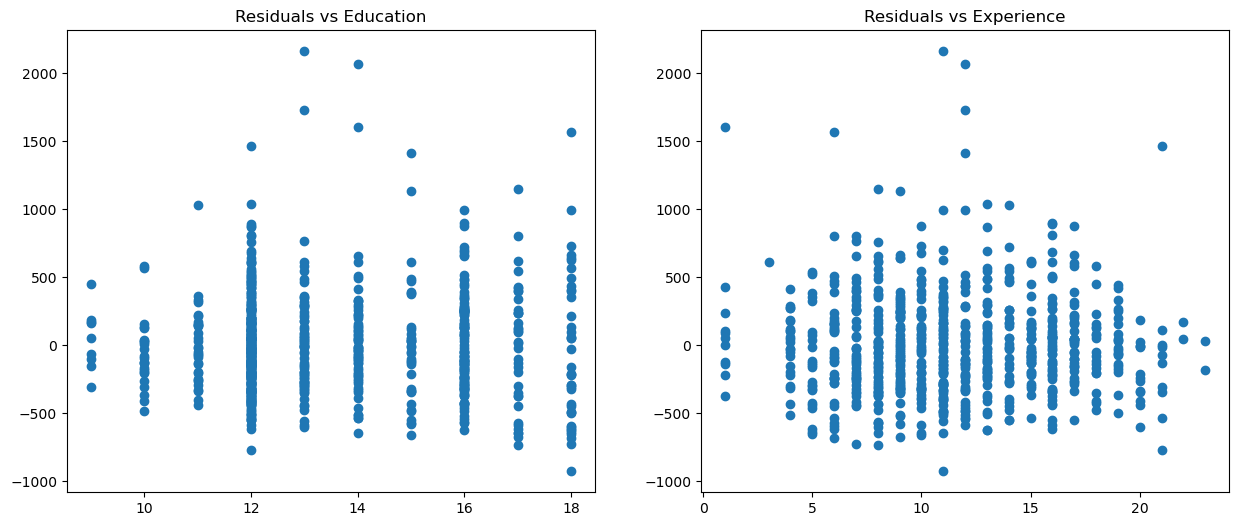

In [89]:
#Residuals against predictors
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(train['educ'], t2_resid)
ax1.set_title("Residuals vs Education")

ax2.scatter(train['exper'], t2_resid)
ax2.set_title("Residuals vs Experience")

plt.show()

### LSA 3: Data is IID

The data represent a cross-sectional survey of income earners, with each row corresponding to a distinct individual. Given that the observations are drawn independently from a population and reflect individual-level attributes, we assume the data satisfy LSA 3, the observations are independent and identically distributed.

### LSA 4: All 4th Moments Exist

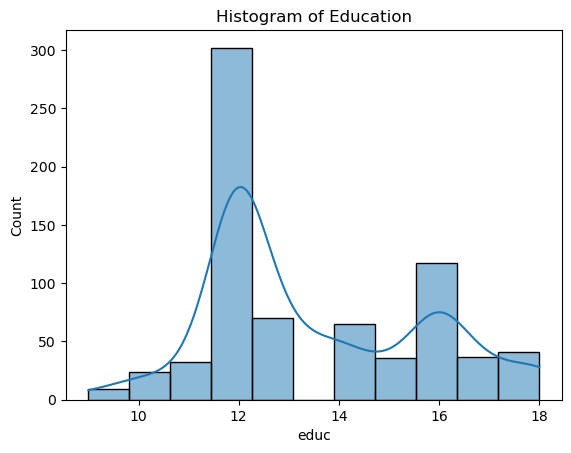

In [93]:
sns.histplot(train['educ'], kde=True)
plt.title("Histogram of Education")
plt.show()

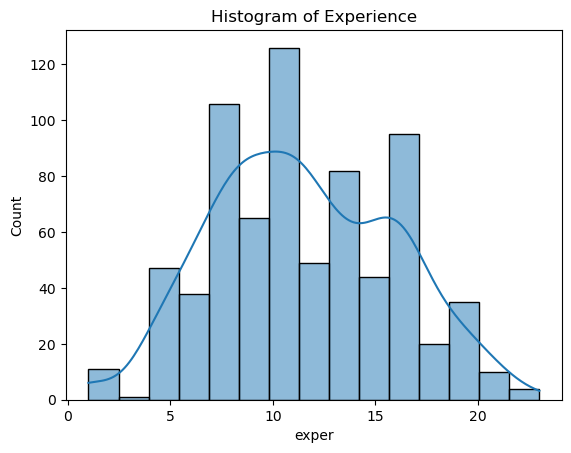

In [94]:
sns.histplot(train['exper'], kde=True)
plt.title("Histogram of Experience")
plt.show()

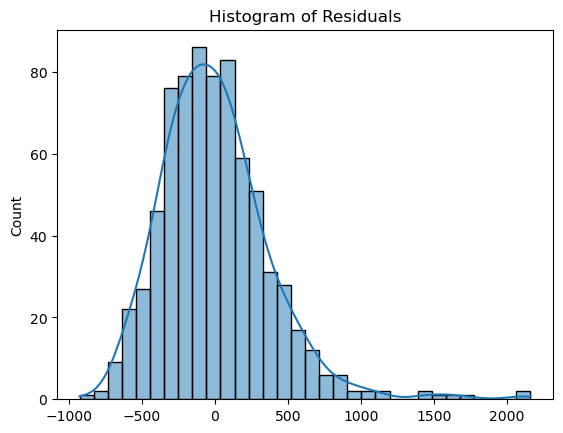

In [95]:
sns.histplot(t2_resid, kde=True)
plt.title("Histogram of Residuals")
plt.show()

### LSA 5: No Perfect Collinearity

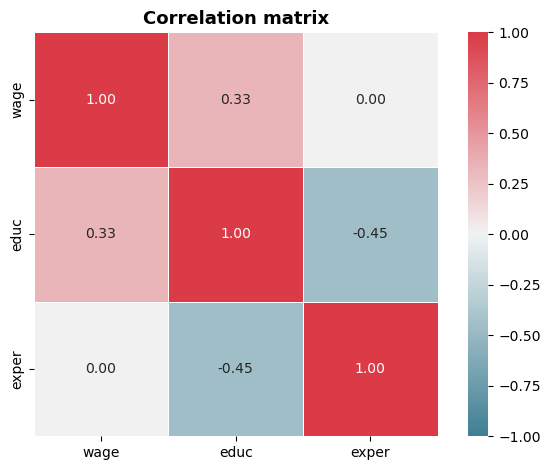

In [97]:
fig, ax = plt.subplots()
variables = ['wage', 'educ', 'exper']
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data[variables].corr(), vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True, fmt='.2f', ax=ax, cmap=cmap)

ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

### LSA 6: Homoskedacity

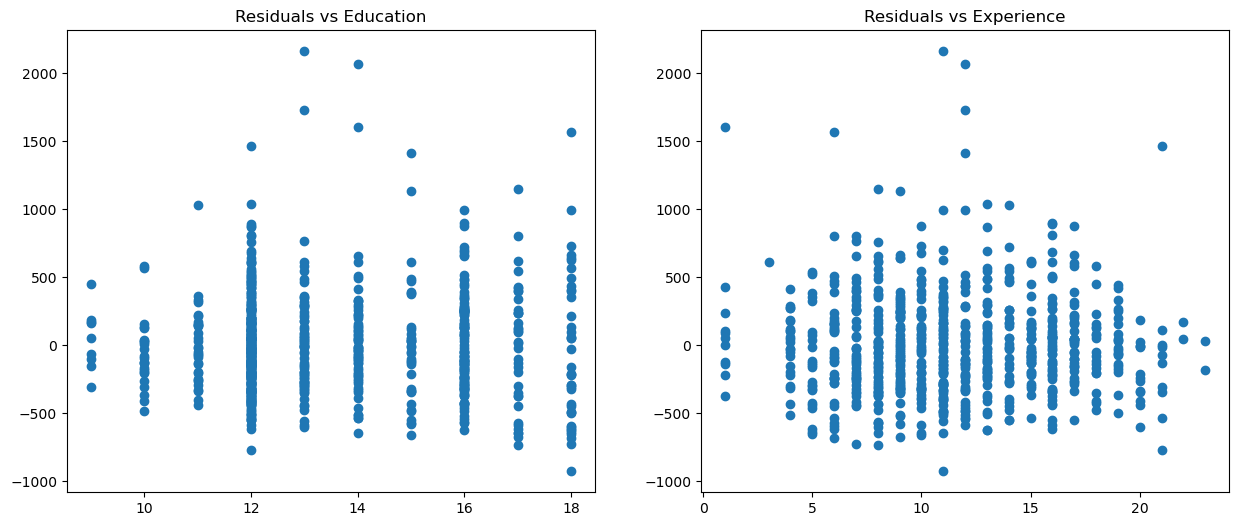

In [99]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(train['educ'], t2_resid)
ax1.set_title('Residuals vs Education')
ax2.scatter(train['exper'], t2_resid)
ax2.set_title('Residuals vs Experience')
plt.show()

# **Task 3**